In [1]:
import pandas as pd
import numpy as np
import os,sys
import json
from tqdm import tqdm

In [2]:
def find_files(folder_path, end_strs):
    txt_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if len([1 for end_str in end_strs if file.endswith(end_str)]) > 0:
                txt_files.append(os.path.join(root, file))
    return txt_files

In [3]:
data_top_dir = '/root/a100_nas_lvbo/peixunban/002754_lvbo/SFT/tulu_v3'
data_files = find_files(data_top_dir, ['parquet'])

In [4]:
target_output_path = '/root/a100_nas_lvbo/peixunban/002754_lvbo/SFT/json/tulu3_all.jsonl'

In [5]:
english_fasttext_model_path = '/root/a100_nas_lvbo/peixunban/002754_lvbo/SFT/lid.176.bin'

In [6]:
{
    "instruction": "人类指令（必填）",
    "input": "人类输入（选填）",
    "output": "模型回答（必填）",
    "system": "系统提示词（选填）",
    "history": [
      ["第一轮指令（选填）", "第一轮回答（选填）"],
      ["第二轮指令（选填）", "第二轮回答（选填）"]
    ]
  }

{'instruction': '人类指令（必填）',
 'input': '人类输入（选填）',
 'output': '模型回答（必填）',
 'system': '系统提示词（选填）',
 'history': [['第一轮指令（选填）', '第一轮回答（选填）'], ['第二轮指令（选填）', '第二轮回答（选填）']]}

In [27]:
sft_data = []
with open(target_output_path, 'w') as fout:
    for data_file in data_files:
        df = pd.read_parquet(data_file)
        for i, row in tqdm(df.iterrows()):
            messages = list(row['messages'])
            source = row['source']
            msg_history = []
            begin = 0 if messages[0]['role'] == 'user' else 1
            for i in range((len(messages)) // 2):
                user_i = begin + i*2
                syst_i = user_i + 1
                if max(syst_i, user_i) >= len(messages):
                    continue
                input = messages[user_i]['content']
                output = messages[syst_i]['content']
                if messages[user_i]['role'] != 'user' or messages[syst_i]['role'] != 'assistant':
                    continue
                msg_history.append([input, output])
            if len(msg_history) == 0:
                continue
            sample = {
                'instruction': msg_history[-1][0],
                'input': '',
                'output': msg_history[-1][1],
                "history": msg_history[:-1],
                'source': source
            }
            sft_data.append(sample)
        print(f'{data_file} {df.shape}')

156557it [00:09, 16205.75it/s]


/root/a100_nas_lvbo/peixunban/002754_lvbo/SFT/tulu_v3/data/train-00001-of-00006.parquet (156557, 3)


156557it [00:09, 16049.04it/s]


/root/a100_nas_lvbo/peixunban/002754_lvbo/SFT/tulu_v3/data/train-00002-of-00006.parquet (156557, 3)


156557it [00:08, 18277.13it/s]


/root/a100_nas_lvbo/peixunban/002754_lvbo/SFT/tulu_v3/data/train-00003-of-00006.parquet (156557, 3)


156558it [00:10, 15273.43it/s]


/root/a100_nas_lvbo/peixunban/002754_lvbo/SFT/tulu_v3/data/train-00000-of-00006.parquet (156558, 3)


156557it [00:09, 16838.55it/s]


/root/a100_nas_lvbo/peixunban/002754_lvbo/SFT/tulu_v3/data/train-00004-of-00006.parquet (156557, 3)


156557it [00:07, 20458.05it/s]

/root/a100_nas_lvbo/peixunban/002754_lvbo/SFT/tulu_v3/data/train-00005-of-00006.parquet (156557, 3)


In [32]:
sft_data[13]

{'instruction': 'configurations for 2019 Hyundai Sonata',
 'input': '',
 'output': 'The 2019 Hyundai Sonata came with a variety of configurations to cater to different drivers’ tastes and requirements. Ranging from the entry-level SE to the luxurious Limited 2.0T, here are the different trim levels available for the 2019 model:\n\n### 1. Sonata SE\n- **2.4L Inline-4 Engine** with 185 horsepower\n- 6-speed automatic transmission\n- 16-inch alloy wheels\n- Blind-spot detection with rear cross-traffic alert\n- 7-inch touchscreen infotainment system with Android Auto and Apple CarPlay\n\n### 2. Sonata SEL\n- Adds features to SE, such as:\n- 17-inch alloy wheels\n- Power driver seat with lumbar support\n- Heated front seats\n- Proximity key entry with push-button start\n- Hands-free smart trunk access\n\n### 3. Sonata Sport\n- Includes SEL features plus:\n- Sport front grille and bumper\n- Dual exhaust\n- Leather-wrapped steering wheel\n- Power tilt-and-slide sunroof\n- Sport seats with lea

In [33]:
import fasttext

In [34]:
model = fasttext.load_model(english_fasttext_model_path)

In [35]:
def is_space_or_punct(s: str) -> bool:
    '''
    Check if a string is empty, or contains only spaces or punctuation.

    Parameters:
        s (str): The string to check.

    Returns:
        bool: True if the string is empty, or contains only spaces or punctuation, otherwise False.
    '''
    punct = set(string.punctuation)
    for char in s:
        if char not in punct and char != ' ':
            return False
    return True

def get_fasttext_lang_prob(model: fasttext.FastText._FastText, text: str) -> (str, float):
    '''
    Function to detect the language of a given text using FastText model.

    Parameters:
        model (fasttext.FastText._FastText): The FastText model to use for language detection.
        text (str): The text whose language is to be detected.

    Returns:
        str: The detected language.
        prob: The probability of the detected language.
    '''
    # Get the language prediction from the model
    predictions = model.predict(text)

    # Extract the language label, and remove the "__label__" prefix
    lang = predictions[0][0].replace("__label__", "")
    prob = predictions[1][0]

    # Return the detected language
    return {lang: prob}

In [36]:
for sample in tqdm(sft_data):
    s1 = sample["instruction"].replace("\n", "")
    s2 = sample["output"].replace("\n", "")
    s3 = " ".join([s[0] + " " + s[1] for s in sample["history"]]).replace("\n", "")
    page_content = f'{s1} {s2} {s3}'
    probs = get_fasttext_lang_prob(model, page_content)
    if 'en' in probs:
        sample['en_lang'] = probs['en']
    else:
        sample['en_lang'] = 0.0

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 939343/939343 [09:50<00:00, 1591.39it/s]


In [37]:
sft_data[100:100+10]

[{'instruction': "Why Do 80's Sitcom Titles Look The Same?",
  'input': '',
  'output': "The similarity in the look of 1980s sitcom titles can be attributed to a few factors, including the design trends of the time, the technology used for graphics and titling, and the desire for networks and producers to create a familiar and comfortable viewing experience for audiences. Here's why many 1980s sitcom titles might seem to have a similar aesthetic:\n\n1. **Typography**: The 1980s saw particular fonts and typography styles become popular. Fonts like Brush Script, which has a casual and friendly feel, were commonly used in sitcom titles to convey a sense of fun and approachability.\n\n2. **Graphics Technology**: The technology available for creating on-screen graphics was limited compared to what's available today. The Chyron graphic generator, for example, was a common tool for creating titles, and it had its own set of standard fonts and styles. The consistency of these tools led to a un

In [38]:
len(sft_data)

939343

In [39]:
sft_data_v2 = []
for sample in tqdm(sft_data):
    if sample['en_lang'] >= 0.85:
        sft_data_v2.append(json.dumps(sample, ensure_ascii=False))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 939343/939343 [00:14<00:00, 63755.06it/s]


In [40]:
with open(target_output_path, 'w') as fout:
    for line in sft_data_v2:
        fout.write(f'{line}\n')
    fout.flush()

In [41]:
import random
random.seed = 1024
random.shuffle(sft_data_v2)
topN = 10000*5
sft_data_v3 = sft_data_v2[:topN]
sft_data_v2 = sft_data_v2[topN:]

In [42]:
target_dir = os.path.dirname(target_output_path)
target_file = os.path.basename(target_output_path)

In [43]:
with open(os.path.join(target_dir, 'A_' + target_file), 'w') as fout:
    for line in sft_data_v2:
        fout.write(f'{line}\n')
    fout.flush()

with open(os.path.join(target_dir, 'B_' + target_file), 'w') as fout:
    for line in sft_data_v3:
        fout.write(f'{line}\n')
    fout.flush()

In [44]:
len(sft_data_v2), len(sft_data_v3), len(sft_data_v2)/len(sft_data), len(sft_data_v3)/len(sft_data)

(405659, 50000, 0.43185396601667336, 0.05322869282040746)

In [61]:
output_lens = [len(json.loads(itm)['output'].split(' ')) for itm in sft_data_v2]
top_10 = sorted(output_lens, reverse=True)[:10]
print(top_10)

[7662, 4850, 3828, 3282, 3214, 3176, 3117, 3078, 3010, 2991]


In [51]:
import numpy as np
import matplotlib.pyplot as plt

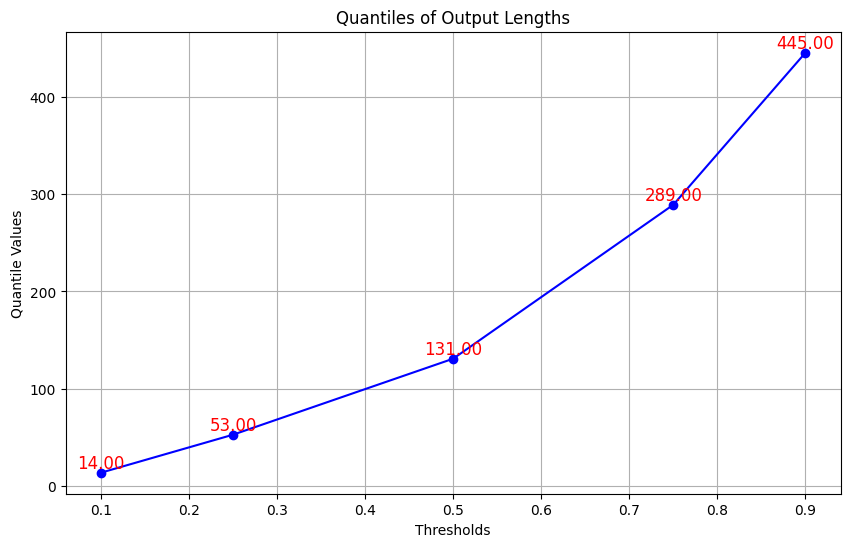

In [53]:
thres = [0.1, 0.25, 0.5, 0.75, 0.9]
list(zip(thres, np.quantile(output_lens,thres)))
# 绘制分位数
quantiles = np.quantile(output_lens, thres)
plt.figure(figsize=(10, 6))
plt.plot(thres, quantiles, marker='o', linestyle='-', color='b')
plt.title('Quantiles of Output Lengths')
plt.xlabel('Thresholds')
plt.ylabel('Quantile Values')
plt.grid(True)

# 标记每个点
for x, y in zip(thres, quantiles):
    plt.text(x, y, f'{y:.2f}', color='red', fontsize=12, ha='center', va='bottom')

plt.show()

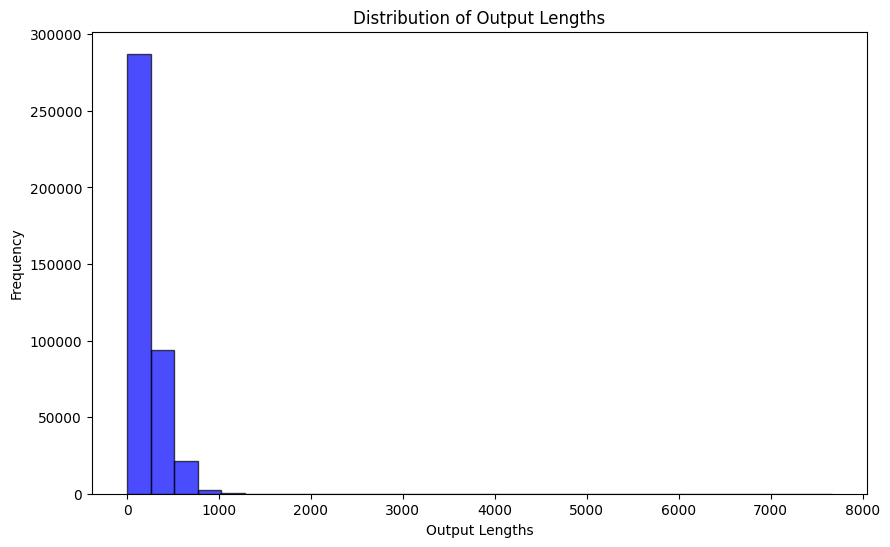

In [60]:
# 假设 output_lens 是之前定义的数据数组
np.random.seed(42)

plt.figure(figsize=(10, 6))
plt.hist(output_lens, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Output Lengths')
plt.xlabel('Output Lengths')
plt.ylabel('Frequency')
plt.show()

In [82]:
### inference ####
from transformers import OlmoForCausalLM, AutoTokenizer

# olmo = OlmoForCausalLM.from_pretrained("/home/lvbo/hf_pt/olmo-20m")
# tokenizer = AutoTokenizer.from_pretrained("/home/lvbo/hf_pt/olmo-20m")
olmo = OlmoForCausalLM.from_pretrained("/home/lvbo/hf_pt/olmo1b_2024_12_06_04_04_24")
tokenizer = AutoTokenizer.from_pretrained("/home/lvbo/hf_pt/olmo1b_2024_12_06_04_04_24", truncate_to=None) # , eos_token_id=0, pad_token_id=1
# olmo = AutoModelForCausalLM.from_pretrained("/home/lvbo/hf_pt/OLMo-1B")
# tokenizer = AutoTokenizer.from_pretrained("/home/lvbo/hf_pt/OLMo-1B")

# message = ["Biology is science, it is based on physics subject. What is your opinion? "]
# message = ["You are an intelligent assistant capable of providing accurate and well-structured answers. Please answer the following question in detail. Question: Explain the significance of renewable energy sources in combating climate change. Provide examples of commonly used renewable energy sources, their advantages, and any challenges associated with their adoption. Make your response structured into three parts: 1) Introduction, 2) Key Examples with Advantages, and 3) Challenges and Conclusion."]
message = ["We live on the earth, not on the moon or the mars, sun, sun, mars, moon, earth, china, japan, korea"]
inputs = tokenizer(message, return_tensors='pt', return_token_type_ids=False)
response = olmo.generate(**inputs, max_new_tokens=500, do_sample=True, top_k=50, top_p=0.95)
print(tokenizer.batch_decode(response, skip_special_tokens=True)[0])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


We live on the earth, not on the moon or the mars, sun, sun, mars, moon, earth, china, japan, korea, in the country that, that the political in which will only in the sun, they said the new, but that the past, that the time, it is that the year, of the first, to the case to "' and. They had to use, as the same time, to the man of the years, the next to the fact by to make our time.

So I'll have the US that a long-Ting of the next years of the whole new side (which, which the rest, and the time of a reason of the whole year in the last-S's, the one of a more of the two, and that the time the top and, which which the way for it, he found this, and when it a good. When the right of the right, even all, but they, the most of the whole time, as "I may have no matter and that it, he would not to "the and, for a human a public of the human, and that had had to have their country, while, and in which they said up to help a different, that the body. We are no new number of the first to be to t